In [1]:
import numpy as np
import matplotlib.pyplot as plt
from main import *

# 使用STO-3G基组+RHF计算HeH+体系

HeH+离子和H2具有相同的电子数，但是并不是一个对称体系，我们使用和H2类似的方法计算HeH+离子的基态能量和布局分析。

首先是产生基组，这里同样使用的是STO-3G基组，分别构建了H和He的1s和2s轨道。

In [2]:
from parameter import STO_3G
STO_1s = STO_3G['1s']
STO_2s = STO_3G['2s']
H_alpha = [STO_1s['alpha'], STO_2s['alpha']]
H_coeff = [STO_1s['coeff'], STO_2s['coeff']]

He_alpha = [[6.362,1.1589,0.313649], [0.151623, 0.851819, 2.941249]]
He_coeff = [[0.15432897,0.53532814,0.44463454],[0.029450, 0.825044, 0.409733]]


In [3]:
#产生基组
def Get_HeH_basis(H,He,alphaH,alphaHe,coeffH,coeffHe):
    basis = []
    for i in range(2):
        basis.append([alphaH[i],coeffH[i],H])
        basis.append([alphaHe[i],coeffHe[i],He])
    return basis
# 结构优化HeH+分子
def SO_HeH(h,R_init,delta=0.05,Z1=1,Z2=2):
    index = 0
    R_history = []
    while True:
        basis_set = []
        H1 = np.array([-(R_init+h)/2, 0.0, 0.0])
        H2 = np.array([(R_init+h)/2, 0.0, 0.0])
        basis_set = []
        for i in range(2):
            for j in range(2):
                basis_set.append([alpha[i], coeff[i], [H1, H2][j]])

        E_ph,_,_ = Iteration(basis_set,H1,H2,Z1,Z2)
        E_ph += Z1*Z2/(R_init+h)
        H1 = np.array([-(R_init-h)/2, 0.0, 0.0])
        H2 = np.array([(R_init-h)/2, 0.0, 0.0])
        basis_set = []
        for i in range(2):
            for j in range(2):
                basis_set.append([alpha[i], coeff[i], [H1, H2][j]])
        E_mh,_,_ = Iteration(basis_set,H1,H2,Z1,Z2)
        E_mh += Z1*Z2/(R_init-h)
        gradient = (E_ph-E_mh)/(2*h)
        R_new = R_init-delta*gradient
        if np.abs(R_new-R_init)<1e-4 or index > 1000:
            print("Optimization finished! The optimized distance is:",R_new)
            break
        else:
            index += 1
            print("Optimization step:",index,"Current distance:",R_new,'Current energy:',E_ph)
            R_init = R_new
            R_history.append(R_new)
    return R_history
    

## 结构优化部分

同样这里使用数值梯度来优化HeH+离子的结构，具体代码见上，这里直接给出优化后的结果。


Optimization step: 1 Current distance: 1.401944443313766 Current energy: -2.7927535544316617
Optimization step: 2 Current distance: 1.4038413371871947 Current energy: -2.792818882214044
Optimization step: 3 Current distance: 1.4056922545200277 Current energy: -2.7928809194662074
Optimization step: 4 Current distance: 1.4074986973825452 Current energy: -2.7929398555458205
Optimization step: 5 Current distance: 1.4092621011417337 Current energy: -2.7929958671031474
Optimization step: 6 Current distance: 1.410983838293087 Current energy: -2.7930491190728035
Optimization step: 7 Current distance: 1.4126652220224576 Current energy: -2.7930997655766348
Optimization step: 8 Current distance: 1.4143075095205302 Current energy: -2.7931479507467603
Optimization step: 9 Current distance: 1.4159119050702837 Current energy: -2.7931938094767874
Optimization step: 10 Current distance: 1.4174795629256685 Current energy: -2.793237468108249
Optimization step: 11 Current distance: 1.419011589998109 Curre

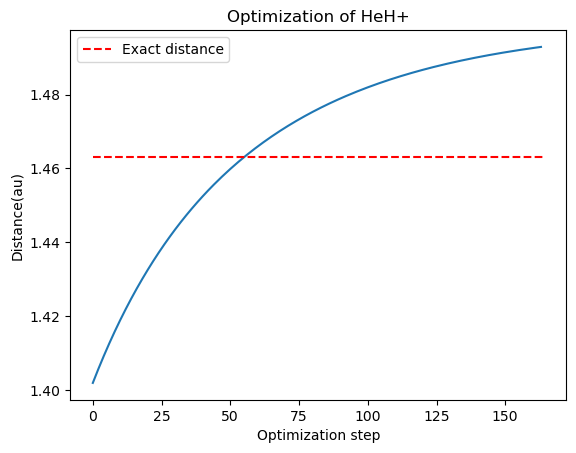

<Figure size 640x480 with 0 Axes>

In [4]:
#结构优化HeH+分子
R_init = 1.4
R_history = SO_HeH(0.01,R_init)
plt.plot(R_history)
plt.hlines(1.4632,0,len(R_history),colors='r',linestyles='dashed',label='Exact distance')
plt.xlabel('Optimization step')
plt.ylabel('Distance(au)')
plt.title('Optimization of HeH+')
plt.legend()
plt.show()
plt.savefig('HeH_opt.png')


## 使用最优结构计算HeH+离子的基态能量和布局分析
这里使用的最优距离为1.4632，使用同样的方法计算HeH+离子的基态能量和布局分析，并且绘制出HeH+离子的电荷分布，成键轨道和反键轨道图。

In [5]:
# 使用HF计算HeH+分子的能量
R = 1.4632
H = np.array([-(R)/2, 0.0, 0.0])
He = np.array([(R)/2, 0.0, 0.0])
basis_set = Get_HeH_basis(H,He,H_alpha,He_alpha,H_coeff,He_coeff)
E,Coeff_matrix,P_matrix = Iteration(basis_set,H,He,1,2)
print("Energy:",E)

# 布居分析
Charge = Mulliken_population(basis_set,P_matrix,H,He,1,2)
atom = {"H":H,"He":He}
for key in Charge.keys():
    if key.startswith("Nuc"):
        name = Charge[key]["Coordinate"]
        name = "H" if name[0] == atom["H"][0] else "He"
        print(name,"Charge:",Charge[key]["Charge"])
print("The Bond order between H and He is:",Charge["Bond"])
print("Total charge:",Charge["Nuc1"]["Charge"]+Charge["Nuc2"]["Charge"])

Energy: -4.229266987915347
H Charge: 0.7575930070466959
He Charge: 0.24240699295330437
The Bond order between H and He is: 0.42605283567394514
Total charge: 1.0000000000000002


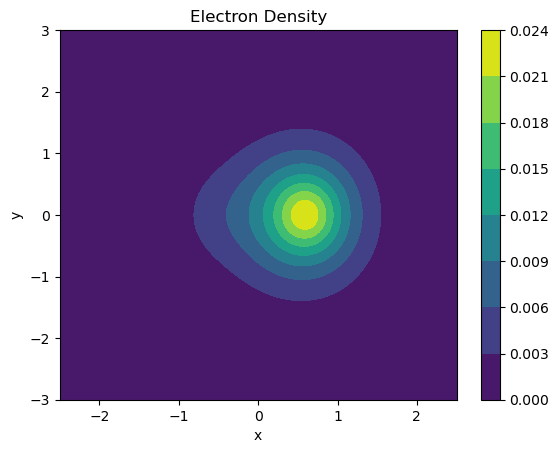

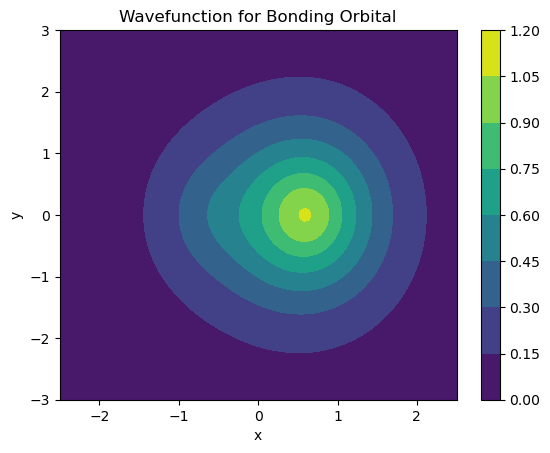

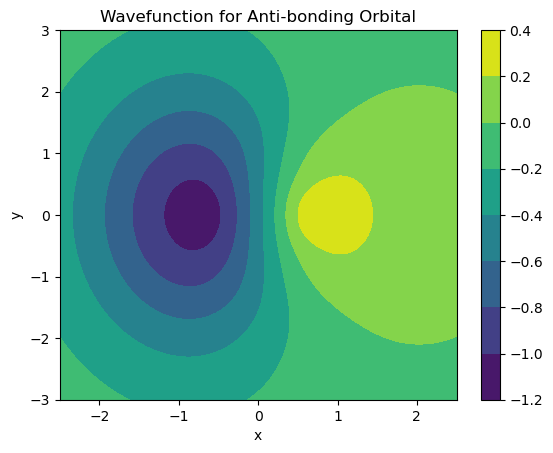

In [6]:
# 电子密度分析
x,y = np.linspace(-3,3,100),np.linspace(-2.5,2.5,100)
X,Y = np.meshgrid(x,y)
D = np.zeros_like(X)
for i in range(len(x)):
    for j in range(len(y)):
        D[i][j] = Density([x[i],y[j],0],basis_set,P_matrix)

plt.contourf(Y,X,D)
plt.colorbar()
plt.title('Electron Density')
plt.xlabel('x')
plt.ylabel('y')

plt.show()

## 波函数分析
W_BO = np.zeros_like(X)
for i in range(len(x)):
    for j in range(len(y)):
        W_BO[i][j] = Wavefunction([x[i],y[j],0],basis_set,Coeff_matrix,index=0)

plt.contourf(Y,X,W_BO)
plt.colorbar()
plt.title('Wavefunction for Bonding Orbital')
plt.xlabel('x')
plt.ylabel('y')

plt.show()


W_AO = np.zeros_like(X)
for i in range(len(x)):
    for j in range(len(y)):
        W_AO[i][j] = Wavefunction([x[i],y[j],0],basis_set,Coeff_matrix,index=1)

plt.contourf(Y,X,W_AO)
plt.colorbar()
plt.title('Wavefunction for Anti-bonding Orbital')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

可以发现正电荷在H上为0.757，He上为0.243，且从电子密度分布图中也可以发现大部分电子都集中在He原子附近，这反映了He的电负性比H大，电子更容易被He原子吸引。

此外可以算出HeH+离子的键级为0.426，这个值比H2的键级要小。